<a href="https://colab.research.google.com/github/jiukeem/deeplearning_from_scratch/blob/master/multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install tensorflow_gpu==2.0.0

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.0.0'

In [5]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [6]:
x_train_all.shape, y_train_all.shape

((60000, 28, 28), (60000,))

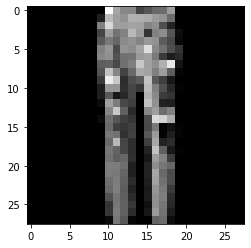

In [7]:
plt.imshow(x_train_all[115], cmap='gray') # imshow는 넘파이배열을 입력받아 이미지를 그림
plt.show()

In [8]:
y_train_all[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

In [9]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [11]:
np.bincount(y_train), np.bincount(y_val)

(array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800]),
 array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]))

In [12]:
x_train = x_train / 255
x_val = x_val / 255
# 픽셀 이미지는 보통 이렇게 normalization 한다고 함. 엄밀히 말하면 다른거지만 이정도로도 충분히 잘 작동함

In [13]:
x_train = x_train.reshape(-1, 784) # 784 = 28 * 28
x_val = x_val.reshape(-1, 784)
x_train.shape, x_val.shape

((48000, 784), (12000, 784))

In [14]:
tf.keras.utils.to_categorical([0, 1, 3]) # 원핫인코딩 해주는 케라스 모듈

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [15]:
y_train[:5], y_val[:5]

(array([6, 6, 3, 3, 0], dtype=uint8), array([5, 4, 5, 2, 1], dtype=uint8))

In [16]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)
y_train_encoded.shape, y_val_encoded.shape

((48000, 10), (12000, 10))

In [17]:
y_train[0], y_train_encoded[0]

(6, array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32))

In [43]:
x_train = x_train[:500]
x_val = x_val[:200]
y_train_encoded = y_train_encoded[:500]
y_val_encoded = y_val_encoded[:200]

In [21]:
class MultiClassNetwork:
  def __init__(self, learning_rate=0.1, num_of_node=10, l2_lambda=0, batch_size=32):
    self.W1 = None
    self.b1 = None
    self.W2 = None
    self.b2 = None
    self.lr = learning_rate
    self.node = num_of_node
    self.cost_history = []
    self.l2 = l2_lambda
    self.val_cost_history = []
    self.batch = batch_size

  def initialization(self, X, Y):
    np.random.seed(42) # 실전에서는 필요없따
    self.W1 = np.random.normal(0, 1, (X.shape[1], self.node))
    self.b1 = np.zeros((1, self.node))
    self.W2 = np.random.normal(0, 1, (self.node, Y.shape[1]))
    self.b2 = np.zeros((1, Y.shape[1]))
    return self.W1, self.b1, self.W2, self.b2 

  def gen_batch(self, X, Y):
    num = X.shape[0] // self.batch
    if X.shape[0] % self.batch:
      num += 1
    index = np.random.permutation(np.arange(X.shape[0]))
    X = X[index]
    Y = Y[index]
    for i in range(num):
      start = i * self.batch
      end = (i + 1) * self.batch 
      yield X[start: end], Y[start: end] # 명시적으로 리스트를 만들지 않고 이터러블 가능한 무언가를 돌려줌
      # 아마도 메모리를 덜 잡아먹나? O
      # 리스트를 만들지 않으면서 필요한만큼 데이터를 추출할 수 있다.
            
  def sigmoid(self, Z1):
    A1 = 1 / (1 + np.exp(-Z1))
    return A1

  def softmax(self, Z2):
    A2 = np.exp(Z2) / (np.sum(np.exp(Z2), axis=1)).reshape(-1, 1)
    return A2

  def forward_prop(self, X):
    Z1 = np.dot(X, self.W1) + self.b1
    A1 = self.sigmoid(Z1)
    Z2 = np.dot(A1, self.W2) + self.b2
    A2 = self.softmax(Z2)
    cache = (Z1, A1, Z2)
    return A2, cache

  def backward_prop(self, X, Y, A2, cache):
    Z1, A1, Z2 = cache
    m = X.shape[0]
    dW2 = np.dot(A1.T, A2 - Y) / m + self.l2 * self.W2
    db2 = np.sum(A2 - Y) / m
    temp = np.dot(A2 - Y, self.W2.T) * A1 * (1 - A1)
    dW1 = np.dot(X.T, temp) / m + self.l2 * self.W1
    db1 = np.sum(temp, axis=0) / m
    gradient = (dW2, db2, dW1, db1)
    return gradient

  def undate_parameter(self, gradient):
    dW2, db2, dW1, db1 = gradient
    self.W2 -= dW2
    self.b2 -= db2
    self.W1 -= dW1
    self.b1 -= db1

  def calcul_cost(self, Y, A2):
    A2 = np.clip(A2, 1e-10, 1-1e-10)
    L = np.sum(-Y * np.log(A2))
    regul = self.l2 / 2 * (np.sum(self.W1 ** 2) + np.sum(self.W2 ** 2))
    L += regul
    cost = np.sum(L) / Y.shape[0]
    return cost

  def fit(self, X, Y, epoch=100, X_val=None, Y_val=None):
    self.W1, self.b1, self.W2, self.b2 = self.initialization(X, Y)
    for i in range(epoch):
      for X_batch, Y_batch in self.gen_batch(X, Y):
        A2, cache = self.forward_prop(X_batch)
        gradient = self.backward_prop(X_batch, Y_batch, A2, cache)
        self.undate_parameter(gradient)
        cost = self.calcul_cost(Y_batch, A2)
        self.cost_history.append(cost)
        self.update_val(X_val, Y_val)
      print(i, end='') # 데이터양도 많고 히든유닛노드를 100개로 설정했으므로 에포크 한개가 굉장히 오래걸린다. 진행되고 있는지 알수있도록 .표시

  def update_val(self, X_val, Y_val):
    A2, _ = self.forward_prop(X_val)
    cost = self.calcul_cost(Y_val, A2)
    self.val_cost_history.append(cost)

  def predict(self, X, Y):
    A2, _ = self.forward_prop(X)
    return np.argmax(A2, axis=1)

  def score(self, X, Y):
    Y_hat = self.predict(X, Y)
    score = np.mean(Y_hat == np.argmax(Y, axis=1))
    return score

In [22]:
fc = MultiClassNetwork(num_of_node=100, batch_size=256)
fc.fit(x_train, y_train_encoded, X_val=x_val, Y_val=y_val_encoded, epoch=40)

0123456789101112131415161718192021222324252627282930313233343536373839

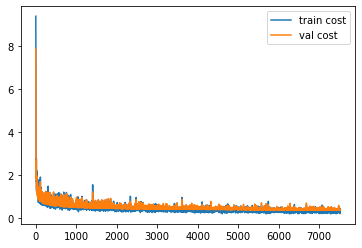

In [23]:
plt.plot(fc.cost_history)
plt.plot(fc.val_cost_history)
plt.legend(['train cost', 'val cost'])
plt.show()

In [24]:
fc.score(x_val, y_val_encoded)

0.8563333333333333